In [10]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the dataset
df = pd.read_csv('../../../../Data/Creation/CSV/Combined_Log_Transformed.csv')

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Rename columns to meet Prophet's requirements
# Prophet requires the columns to be named 'ds' for the datestamp and 'y' for the metric to forecast
prophet_df = df.rename(columns={'date': 'ds', 'Real Oil Prices': 'y'})

# Display the first few rows of the DataFrame
prophet_df.head()

,ds,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,y
0,1986-01-01,8.817058,8.688117,3.857715,13.408814,11.719838,4.019102,4.149063,4.123819,4.290384,...,3.818964,2.315501,2.465554,2.254445,4.560173,11.178487,11.711347,6.117475,2.897088,3.038045
1,1986-02-01,8.821909,8.693279,3.855241,13.403109,11.710476,4.012230,4.139512,4.113869,4.281726,...,3.823585,2.316488,2.468100,2.257588,4.563306,11.191452,11.721119,6.117194,3.026465,2.645677
2,1986-03-01,8.831298,8.702643,3.858643,13.404085,11.703515,4.005200,4.136150,4.110498,4.278101,...,3.827946,2.317474,2.462150,2.259678,4.554929,11.207555,11.730876,6.109472,3.159720,2.447396
3,1986-04-01,8.834686,8.705961,3.864785,13.424021,11.709872,4.006344,4.139662,4.111926,4.284721,...,3.829749,2.318459,2.468947,2.257588,4.566429,11.231676,11.744940,6.120473,3.136164,2.469144
4,1986-05-01,8.835888,8.706755,3.870784,13.414384,11.724289,4.008305,4.143116,4.114232,4.290291,...,3.831030,2.320425,2.473171,2.260721,4.551769,11.269783,11.768419,6.127810,2.938781,2.646890


## Model Training and Forecasting

08:39:22 - cmdstanpy - INFO - Chain [1] start processing
08:39:22 - cmdstanpy - INFO - Chain [1] done processing


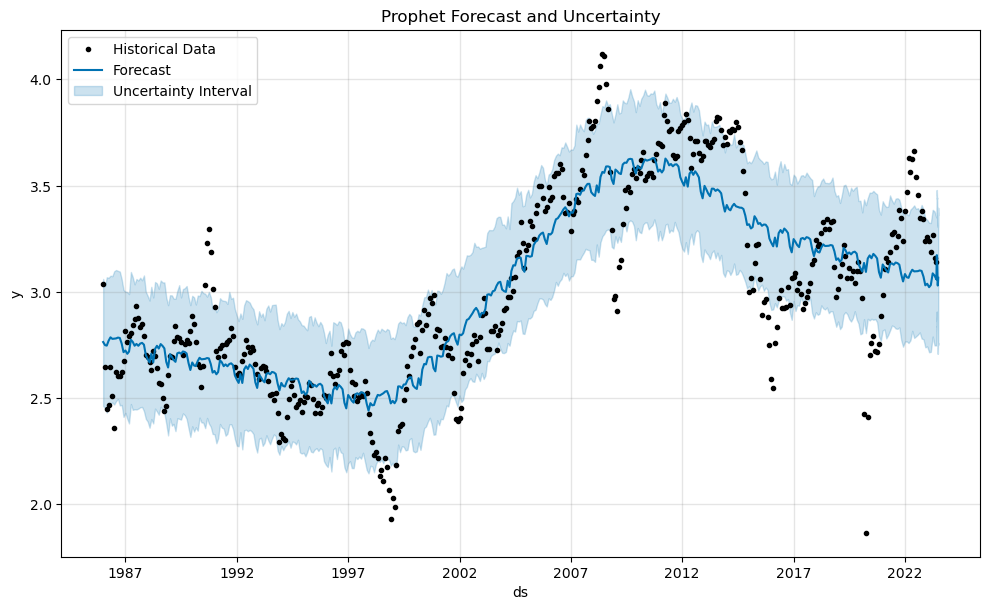

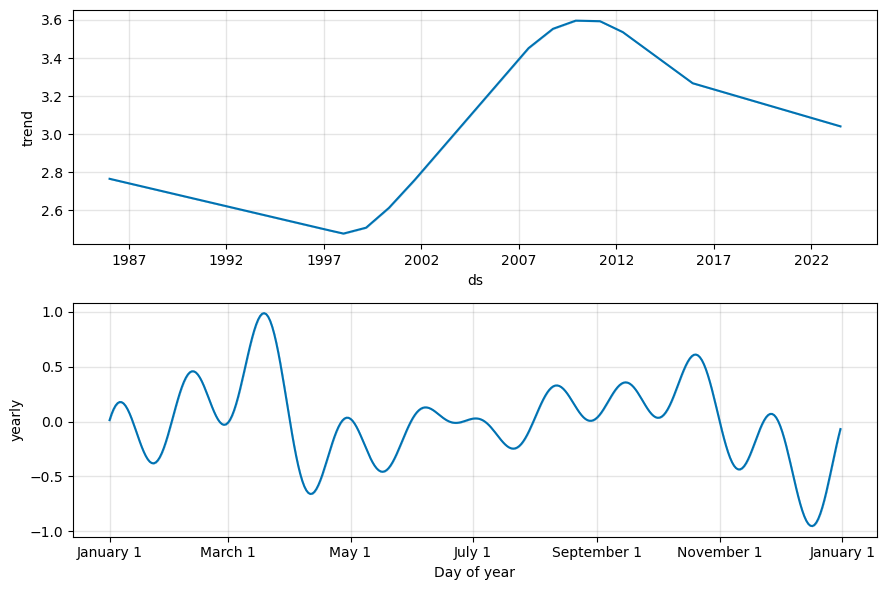

In [11]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_df)

# Create a DataFrame with future dates for forecasting (30 days into the future)
future = model.make_future_dataframe(periods=30)

# Generate forecasts
forecast = model.predict(future)

# Plot the historical data and forecasts
fig1 = model.plot(forecast)
plt.legend(labels=['Historical Data', 'Forecast', 'Uncertainty Interval'], loc='upper left')
plt.title('Prophet Forecast and Uncertainty')
plt.show()

# Plot the components of the forecast (trend, weekly, yearly)
fig2 = model.plot_components(forecast)
plt.show()

- Actual: This represents the actual data points from the dataset.
- Forecast: This is the forecasted values generated by the Prophet model for the future dates.
- Uncertainty Interval: This is the confidence interval around the forecasts, indicating the range within which the actual values are likely to fall with a certain level of confidence.

#### Parameter Tuning - `changepoint_prior_scale` which controls how sensitive the model is to potential changepoints where the trend changes.
- Higher values will make the trend more flexible, lower values will make the trend less flexible.

### Calculate Performance Metrics

In [12]:
# Calculate forecast error metrics using the historical data
y_true = prophet_df['y']
y_pred = forecast.loc[:len(y_true)-1, 'yhat']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Display the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 0.18
Mean Squared Error (MSE): 0.06
Root Mean Squared Error (RMSE): 0.24
R^2 Score: 0.73
Mean Absolute Percentage Error (MAPE): 6.19%


### Parameter Tuning for Changepoint Sensitivity

08:39:23 - cmdstanpy - INFO - Chain [1] start processing
08:39:23 - cmdstanpy - INFO - Chain [1] done processing


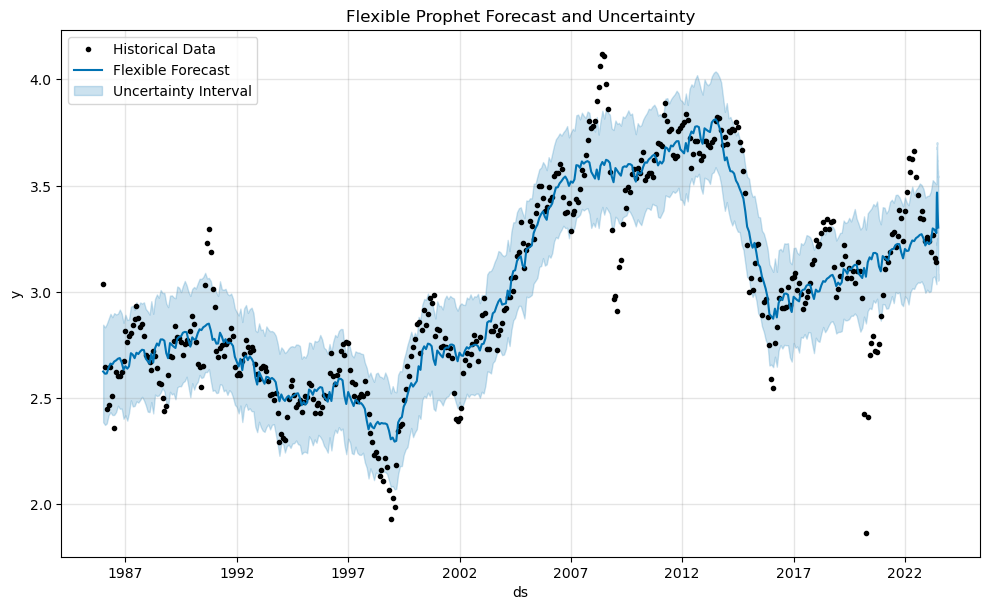

In [13]:
# Tune the changepoint_prior_scale for more flexible trend
flexible_model = Prophet(changepoint_prior_scale=0.5)
flexible_model.fit(prophet_df)

# Create a DataFrame with future dates for forecasting (30 days into the future)
future_flexible = flexible_model.make_future_dataframe(periods=30)

# Generate forecasts with the flexible model
forecast_flexible = flexible_model.predict(future_flexible)

# Plot the historical data and the flexible forecasts
fig3 = flexible_model.plot(forecast_flexible)
plt.legend(labels=['Historical Data', 'Flexible Forecast', 'Uncertainty Interval'], loc='upper left')
plt.title('Flexible Prophet Forecast and Uncertainty')
plt.show()

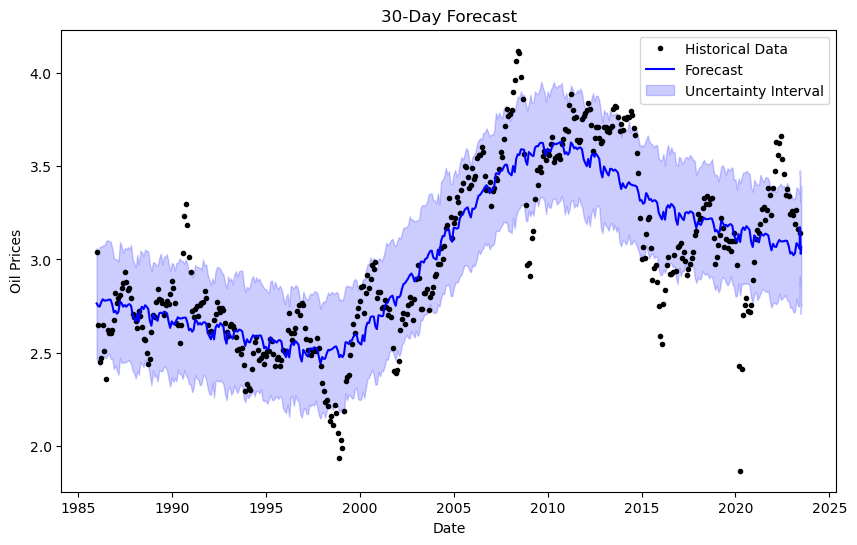

In [17]:
# Plot the forecast for the future 30-day period
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the historical data
ax.plot(prophet_df['ds'], prophet_df['y'], 'k.', label='Historical Data')
# Plot the predicted means as a blue line for the entire forecast period
ax.plot(forecast['ds'], forecast['yhat'], ls='-', color='blue', label='Forecast')
# Plot the prediction intervals as a shaded area for the entire forecast period
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

# Highlight the 30-day prediction period with a vertical line
ax.axvline(x=prophet_df['ds'].iloc[-1], color='red', linestyle='--', lw=1, label='Start of Forecast')

# Set labels and titles
ax.set_xlabel('Date')
ax.set_ylabel('Oil Prices')
ax.set_title('30-Day Forecast')
ax.legend()

plt.show()

In [15]:
# Check the last date of historical data
last_historical_date = prophet_df['ds'].iloc[-1]
print(f"Last historical date: {last_historical_date}")

# Check the first date of forecast beyond historical data
first_forecasted_date = forecast.loc[len(prophet_df):, 'ds'].iloc[0]
print(f"First forecasted date: {first_forecasted_date}")


Last historical date: 2023-06-01 00:00:00
First forecasted date: 2023-06-02 00:00:00


In [16]:
# Check the future dates in forecast dataframe
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds      yhat  yhat_lower  yhat_upper
475 2023-06-27  3.044030    2.748070    3.364122
476 2023-06-28  3.050146    2.752007    3.374480
477 2023-06-29  3.056272    2.760949    3.361380
478 2023-06-30  3.061848    2.750447    3.395988
479 2023-07-01  3.066321    2.767022    3.392411
